In [1]:
import pandas as pd
import numpy as np

    df = pd.read_csv('merged_10_cryptos_history.csv')
except FileNotFoundError:
    print("Error: The file 'merged_10_cryptos_history.csv' was not found. Please ensure it is in the same directory.")
    raise

if 'Unnamed: 0' in df.columns:
    df = df.drop('Unnamed: 0', axis=1)

def clean_numeric_col(series):
    
    return series.astype(str).str.replace(r'[$,-]', '', regex=True).replace('', np.nan).astype(float)

df['market_cap'] = clean_numeric_col(df['market_cap'])
df['volume'] = clean_numeric_col(df['volume'])

price_cols = ['close', 'high', 'low', 'open']
for col in price_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(by=['Coin_Name', 'date']).reset_index(drop=True)
cols_to_fill = price_cols + ['market_cap', 'volume']
for col in cols_to_fill:
   
    df[col] = df.groupby('Coin_Name')[col].ffill()
    df[col] = df.groupby('Coin_Name')[col].bfill()

df['close_lag_1'] = df.groupby('Coin_Name')['close'].shift(1)
df['close_lag_7'] = df.groupby('Coin_Name')['close'].shift(7)
df['close_lag_30'] = df.groupby('Coin_Name')['close'].shift(30)

df['SMA_7'] = df.groupby('Coin_Name')['close'].transform(lambda x: x.rolling(window=7, min_periods=1).mean())
df['SMA_30'] = df.groupby('Coin_Name')['close'].transform(lambda x: x.rolling(window=30, min_periods=1).mean())

df['Vol_7'] = df.groupby('Coin_Name')['close'].transform(lambda x: x.rolling(window=7, min_periods=1).std())

df['Vol_7'] = df.groupby('Coin_Name')['Vol_7'].bfill().ffill() 

df['Daily_Return'] = df.groupby('Coin_Name')['close'].pct_change(1)

df['close_next_day'] = df.groupby('Coin_Name')['close'].shift(-1)

df.dropna(subset=['close_next_day'], inplace=True)

df.dropna(inplace=True)

df.to_csv('cleaned_features_crypto.csv', index=False)

print("--- Data Cleaning and Feature Engineering Complete ---")
print(f"A new file has been created: 'cleaned_features_crypto.csv'")
print(f"Final dataset shape: {df.shape}")
print("\nFirst 5 rows of the processed data (features and target):")
print(df[['date', 'Coin_Name', 'close', 'close_lag_1', 'SMA_7', 'Vol_7', 'Daily_Return', 'close_next_day']].head())

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5228\4053134074.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['date'] = pd.to_datetime(df['date'])


--- Data Cleaning and Feature Engineering Complete ---
A new file has been created: 'cleaned_features_crypto.csv'
Final dataset shape: (7354, 16)

First 5 rows of the processed data (features and target):
         date Coin_Name     close  close_lag_1     SMA_7     Vol_7  \
30 2015-12-09  1337Coin  0.000062     0.000070  0.000075  0.000011   
31 2015-12-10  1337Coin  0.000072     0.000062  0.000075  0.000011   
32 2015-12-11  1337Coin  0.000049     0.000072  0.000070  0.000013   
33 2015-12-12  1337Coin  0.000043     0.000049  0.000063  0.000013   
34 2015-12-13  1337Coin  0.000048     0.000043  0.000058  0.000012   

    Daily_Return  close_next_day  
30     -0.114286        0.000072  
31      0.161290        0.000049  
32     -0.319444        0.000043  
33     -0.122449        0.000048  
34      0.116279        0.000038  


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import datetime as dt

df_model = pd.read_csv('cleaned_features_crypto.csv')
df_model['date'] = pd.to_datetime(df_model['date']) 

feature_cols = [
    'close_lag_1', 'close_lag_7', 'close_lag_30', 
    'SMA_7', 'SMA_30', 'Vol_7', 'Daily_Return',
    'open', 'high', 'low', 'volume', 'market_cap' 
]
target_col = 'close_next_day'

X = df_model[feature_cols]
y = df_model[target_col]

split_date_train = df_model['date'].quantile(0.7)
split_date_test = df_model['date'].quantile(0.9)


train_mask = df_model['date'] <= split_date_train
X_train = X[train_mask]
y_train = y[train_mask]

val_mask = (df_model['date'] > split_date_train) & (df_model['date'] <= split_date_test)
X_val = X[val_mask]
y_val = y[val_mask]

test_mask = df_model['date'] > split_date_test
X_test = X[test_mask]
y_test = y[test_mask]


scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)

scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()

print("\n--- Training SVR (C=10, gamma='auto') ---")

svr_model = SVR(kernel='rbf', C=10, gamma='auto', cache_size=1000)
svr_model.fit(X_train_scaled, y_train_scaled)

y_pred_val_scaled = svr_model.predict(X_val_scaled)

y_pred_val_svr = scaler_y.inverse_transform(y_pred_val_scaled.reshape(-1, 1)).flatten()

mse_svr = mean_squared_error(y_val, y_pred_val_svr)
mae_svr = mean_absolute_error(y_val, y_pred_val_svr)

print(f"\n--- SVR Performance (Validation Set) ---")
print(f"Mean Squared Error (MSE): {mse_svr:.6f}")
print(f"Mean Absolute Error (MAE): {mae_svr:.6f}")


--- Training SVR (C=10, gamma='auto') ---

--- SVR Performance (Validation Set) ---
Mean Squared Error (MSE): 10948771.064936
Mean Absolute Error (MAE): 1151.505640


In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler

# Load the processed data
df_model = pd.read_csv('cleaned_features_crypto.csv')
df_model['date'] = pd.to_datetime(df_model['date'])

# Define Features
feature_cols = [
    'close_lag_1', 'close_lag_7', 'close_lag_30', 
    'SMA_7', 'SMA_30', 'Vol_7', 'Daily_Return',
    'open', 'high', 'low', 'volume', 'market_cap' 
]
target_col = 'close_next_day'

X = df_model[feature_cols]
y = df_model[target_col]

# 2. Time-Series Splitting 
split_date_train = df_model['date'].quantile(0.7)
split_date_test = df_model['date'].quantile(0.9)

# Create train and validation masks
train_mask = df_model['date'] <= split_date_train
val_mask = (df_model['date'] > split_date_train) & (df_model['date'] <= split_date_test)

X_train = X[train_mask]
y_train = y[train_mask]
X_val = X[val_mask]
y_val = y[val_mask]

# --- 3. Feature Scaling ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# --- 4. Model Training and Evaluation ---
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

y_pred_lr = lr_model.predict(X_val_scaled)

mse_lr = mean_squared_error(y_val, y_pred_lr)
mae_lr = mean_absolute_error(y_val, y_pred_lr)

print(f"\n--- Linear Regression Performance (Validation Set) ---")
print(f"Mean Squared Error (MSE): {mse_lr:.6f}")
print(f"Mean Absolute Error (MAE): {mae_lr:.6f}")


--- Linear Regression Performance (Validation Set) ---
Mean Squared Error (MSE): 89737.522508
Mean Absolute Error (MAE): 75.154880


In [12]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Load the processed data
df_model = pd.read_csv('cleaned_features_crypto.csv')
df_model['date'] = pd.to_datetime(df_model['date'])

#Data Splitting Setup
feature_cols = [
    'close_lag_1', 'close_lag_7', 'close_lag_30', 
    'SMA_7', 'SMA_30', 'Vol_7', 'Daily_Return',
    'open', 'high', 'low', 'volume', 'market_cap' 
]
target_col = 'close_next_day'

X = df_model[feature_cols]
y = df_model[target_col]

split_date_train = df_model['date'].quantile(0.7)
val_mask = (df_model['date'] > split_date_train) & (df_model['date'] <= df_model['date'].quantile(0.9))

X_train = X[df_model['date'] <= split_date_train]
y_train = y[df_model['date'] <= split_date_train]
X_val = X[val_mask]
y_val = y[val_mask]

# --- Model Training: Random Forest ---
print("\n--- Training Random Forest Model ---")

rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1, max_depth=10)
rf_model.fit(X_train, y_train)

# Predict on the validation set
y_pred_rf = rf_model.predict(X_val)

# Evaluate the model
mse_rf = mean_squared_error(y_val, y_pred_rf)
mae_rf = mean_absolute_error(y_val, y_pred_rf)

print(f"\n--- Random Forest Performance (Validation Set) ---")
print(f"Mean Squared Error (MSE): {mse_rf:.6f}")
print(f"Mean Absolute Error (MAE): {mae_rf:.6f}")


--- Training Random Forest Model ---

--- Random Forest Performance (Validation Set) ---
Mean Squared Error (MSE): 7946033.487170
Mean Absolute Error (MAE): 894.386382


In [13]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

df_model = pd.read_csv('cleaned_features_crypto.csv')
df_model['date'] = pd.to_datetime(df_model['date'])

# Data Splitting Setup
feature_cols = [
    'close_lag_1', 'close_lag_7', 'close_lag_30', 
    'SMA_7', 'SMA_30', 'Vol_7', 'Daily_Return',
    'open', 'high', 'low', 'volume', 'market_cap' 
]
target_col = 'close_next_day'

X = df_model[feature_cols]
y = df_model[target_col]

split_date_train = df_model['date'].quantile(0.7)
val_mask = (df_model['date'] > split_date_train) & (df_model['date'] <= df_model['date'].quantile(0.9))

X_train = X[df_model['date'] <= split_date_train]
y_train = y[df_model['date'] <= split_date_train]
X_val = X[val_mask]
y_val = y[val_mask]

# --- Model Training: Random Forest 
print("\n--- Training Random Forest Model (Tuned) ---")
rf_model_tuned = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1) 
rf_model_tuned.fit(X_train, y_train)

# Predict on the validation set
y_pred_rf_tuned = rf_model_tuned.predict(X_val)

# Evaluate the model
mse_rf_tuned = mean_squared_error(y_val, y_pred_rf_tuned)
mae_rf_tuned = mean_absolute_error(y_val, y_pred_rf_tuned)

print(f"\n--- Random Forest Performance (Tuned Validation Set) ---")
print(f"Mean Squared Error (MSE): {mse_rf_tuned:.6f}")
print(f"Mean Absolute Error (MAE): {mae_rf_tuned:.6f}")


--- Training Random Forest Model (Tuned) ---

--- Random Forest Performance (Tuned Validation Set) ---
Mean Squared Error (MSE): 7962135.692697
Mean Absolute Error (MAE): 896.020702


In [14]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load Data and Define Splits
df_model = pd.read_csv('cleaned_features_crypto.csv')
df_model['date'] = pd.to_datetime(df_model['date'])

feature_cols = [
    'close_lag_1', 'close_lag_7', 'close_lag_30', 
    'SMA_7', 'SMA_30', 'Vol_7', 'Daily_Return',
    'open', 'high', 'low', 'volume', 'market_cap' 
]
target_col = 'close_next_day'

X = df_model[feature_cols]
y = df_model[target_col]
split_date_test = df_model['date'].quantile(0.9)

# Combined Train/Validation Set
train_val_mask = df_model['date'] <= split_date_test
X_train_val = X[train_val_mask]
y_train_val = y[train_val_mask]

# Final Test Set
test_mask = df_model['date'] > split_date_test
X_test = X[test_mask]
y_test = y[test_mask]

print(f"Final Model will be trained on data up to: {split_date_test.strftime('%Y-%m-%d')}")
print(f"Test Set period starts after: {split_date_test.strftime('%Y-%m-%d')}")
print(f"X_train_val shape: {X_train_val.shape}, X_test shape: {X_test.shape}")


# 2. Scaling and Training on Combined Set
scaler = StandardScaler()
X_train_val_scaled = scaler.fit_transform(X_train_val)
X_test_scaled = scaler.transform(X_test)

final_lr_model = LinearRegression()
final_lr_model.fit(X_train_val_scaled, y_train_val)

# 3. Prediction and Evaluation on Test Set
y_pred_test = final_lr_model.predict(X_test_scaled)

mse_test = mean_squared_error(y_test, y_pred_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

print(f"\n--- Linear Regression Final Performance (Test Set) ---")
print(f"Mean Absolute Error (MAE): {mae_test:.4f}")
print(f"Mean Squared Error (MSE): {mse_test:.4f}")
print(f"R-squared (R^2) Score: {r2_test:.4f} ({r2_test * 100:.2f}%)")

Final Model will be trained on data up to: 2018-03-15
Test Set period starts after: 2018-03-15
X_train_val shape: (6622, 12), X_test shape: (732, 12)

--- Linear Regression Final Performance (Test Set) ---
Mean Absolute Error (MAE): 31.3863
Mean Squared Error (MSE): 13894.2835
R-squared (R^2) Score: 0.9980 (99.80%)


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

# 1. Data Setup and Model Training 

df_model = pd.read_csv('cleaned_features_crypto.csv')
df_model['date'] = pd.to_datetime(df_model['date'])

feature_cols = [
    'close_lag_1', 'close_lag_7', 'close_lag_30', 
    'SMA_7', 'SMA_30', 'Vol_7', 'Daily_Return',
    'open', 'high', 'low', 'volume', 'market_cap' 
]
target_col = 'close_next_day'

X = df_model[feature_cols]
y = df_model[target_col]

# Define the split point for the Test Set 
split_date_test = df_model['date'].quantile(0.9)

# Combined Train/Validation Set
train_val_mask = df_model['date'] <= split_date_test
X_train_val = X[train_val_mask]
y_train_val = y[train_val_mask]

# Final Test Set 
test_mask = df_model['date'] > split_date_test
X_test = X[test_mask]
y_test = y[test_mask]
date_test = df_model[test_mask]['date']

# Scaling and Training
scaler = StandardScaler()
X_train_val_scaled = scaler.fit_transform(X_train_val)
X_test_scaled = scaler.transform(X_test)

final_lr_model = LinearRegression()
final_lr_model.fit(X_train_val_scaled, y_train_val)

# Prediction on Test Set
y_pred_test = final_lr_model.predict(X_test_scaled)


# --- 2. Plot 1: Actual vs. Predicted Prices (Time Series) ---

# Create a DataFrame for easy plotting of the time series
plot_df = pd.DataFrame({
    'date': date_test,
    'Actual Price': y_test,
    'Predicted Price': y_pred_test
}).set_index('date')

plt.figure(figsize=(14, 6))
plt.plot(plot_df.index, plot_df['Actual Price'], label='Actual Price', color='blue', linewidth=2)
plt.plot(plot_df.index, plot_df['Predicted Price'], label='Predicted Price (LR)', color='red', linestyle='--', linewidth=1.5)

# Add R^2 to the plot title
r2_score_test = r2_score(y_test, y_pred_test)
plt.title(f'Actual vs. Predicted Cryptocurrency Prices (Test Set) | $R^2$ = {r2_score_test:.4f}', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price (USD/BTC equivalent)', fontsize=12)
plt.legend(loc='upper left')
plt.grid(True, linestyle=':', alpha=0.6)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('lr_actual_vs_predicted.png')
plt.close()


# --- 3. Plot 2: Feature Importance (Coefficients) ---

# Extract coefficients
coefficients = final_lr_model.coef_
feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Coefficient': coefficients
})
feature_importance['Abs_Coefficient'] = feature_importance['Coefficient'].abs()
feature_importance = feature_importance.sort_values(by='Abs_Coefficient', ascending=False)

plt.figure(figsize=(10, 7))
# Create a bar plot using the sorted coefficients
bars = plt.barh(feature_importance['Feature'], feature_importance['Coefficient'], 
                color=np.where(feature_importance['Coefficient'] > 0, 'skyblue', 'lightcoral'))

plt.xlabel('Scaled Coefficient Value', fontsize=12)
plt.title('Linear Regression Feature Importance (Scaled Coefficients)', fontsize=14)
plt.grid(axis='x', linestyle=':', alpha=0.6)
plt.gca().invert_yaxis() # Put the most important feature at the top
plt.tight_layout()
plt.savefig('lr_feature_importance.png')
plt.close()

print("Two plots have been generated and saved:")
print("- 'lr_actual_vs_predicted.png': Shows the time series fit on the test set.")
print("- 'lr_feature_importance.png': Shows the importance of each feature.")

Matplotlib is building the font cache; this may take a moment.


Two plots have been generated and saved:
- 'lr_actual_vs_predicted.png': Shows the time series fit on the test set.
- 'lr_feature_importance.png': Shows the importance of each feature.


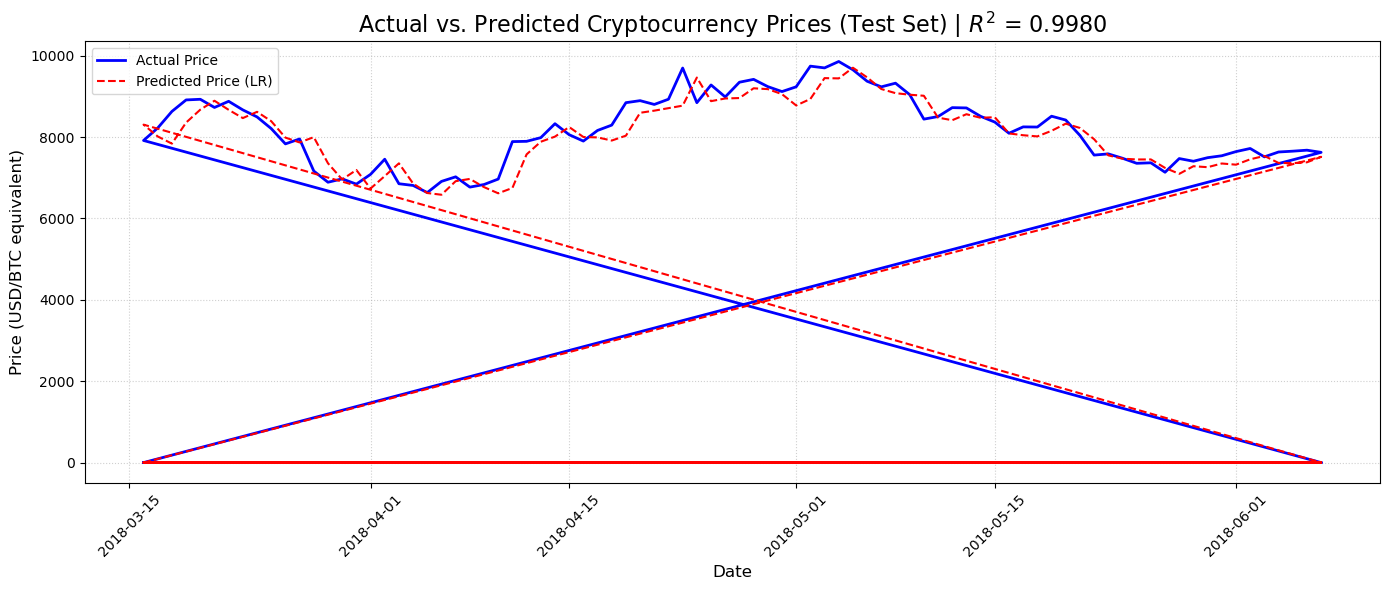

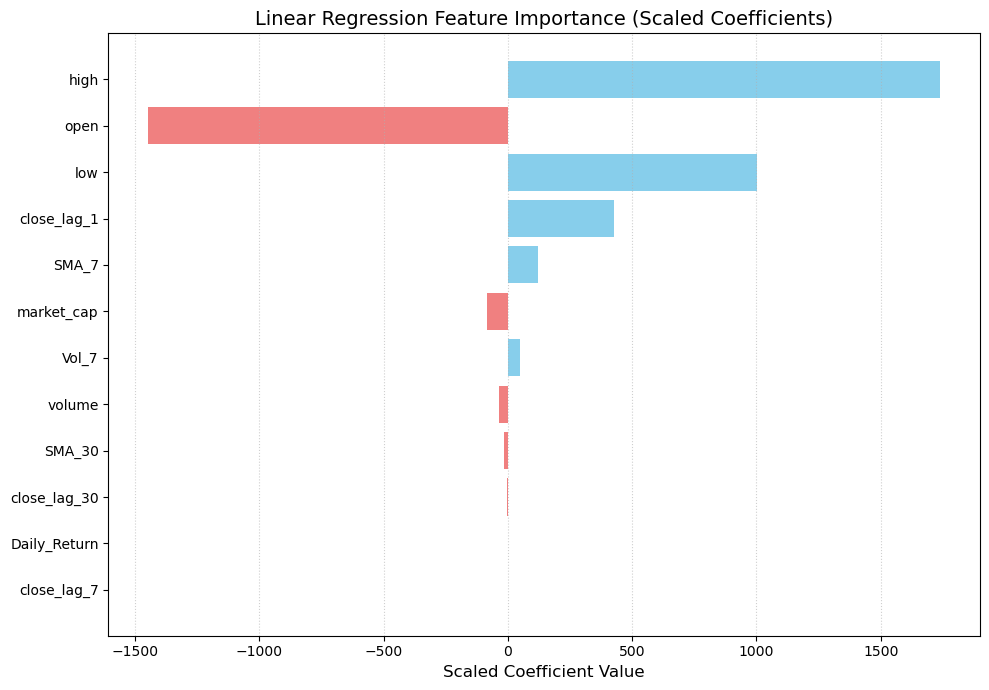

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

# --- 1. Data Setup and Model Training ---

# Load the processed data (assuming 'cleaned_features_crypto.csv' is in your directory)
df_model = pd.read_csv('cleaned_features_crypto.csv')
df_model['date'] = pd.to_datetime(df_model['date'])

feature_cols = [
    'close_lag_1', 'close_lag_7', 'close_lag_30', 
    'SMA_7', 'SMA_30', 'Vol_7', 'Daily_Return',
    'open', 'high', 'low', 'volume', 'market_cap' 
]
target_col = 'close_next_day'

X = df_model[feature_cols]
y = df_model[target_col]

# Define the split point for the Test Set (90% of the data)
split_date_test = df_model['date'].quantile(0.9)

# Combined Train/Validation Set (90% of data)
train_val_mask = df_model['date'] <= split_date_test
X_train_val = X[train_val_mask]
y_train_val = y[train_val_mask]

# Final Test Set (Last 10% of data)
test_mask = df_model['date'] > split_date_test
X_test = X[test_mask]
y_test = y[test_mask]
date_test = df_model[test_mask]['date'] # Get dates for plotting

# Scaling and Training
scaler = StandardScaler()
X_train_val_scaled = scaler.fit_transform(X_train_val)
X_test_scaled = scaler.transform(X_test)

final_lr_model = LinearRegression()
final_lr_model.fit(X_train_val_scaled, y_train_val)

# Prediction on Test Set
y_pred_test = final_lr_model.predict(X_test_scaled)


#2. Plot 1: Actual vs. Predicted Prices

plot_df = pd.DataFrame({
    'date': date_test,
    'Actual Price': y_test.values,
    'Predicted Price': y_pred_test
}).set_index('date')

plt.figure(figsize=(14, 6))
plt.plot(plot_df.index, plot_df['Actual Price'], label='Actual Price', color='blue', linewidth=2)
plt.plot(plot_df.index, plot_df['Predicted Price'], label='Predicted Price (LR)', color='red', linestyle='--', linewidth=1.5)

r2_score_test = r2_score(y_test, y_pred_test)
plt.title(f'Actual vs. Predicted Cryptocurrency Prices (Test Set) | $R^2$ = {r2_score_test:.4f}', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price (USD/BTC equivalent)', fontsize=12)
plt.legend(loc='upper left')
plt.grid(True, linestyle=':', alpha=0.6)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show() # Display the plot in the notebook


#3. Plot 2: Feature Importance

coefficients = final_lr_model.coef_
feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Coefficient': coefficients
})
feature_importance['Abs_Coefficient'] = feature_importance['Coefficient'].abs()
feature_importance = feature_importance.sort_values(by='Abs_Coefficient', ascending=False)

plt.figure(figsize=(10, 7))
# Create a bar plot using the sorted coefficients
plt.barh(feature_importance['Feature'], feature_importance['Coefficient'], 
         color=np.where(feature_importance['Coefficient'] > 0, 'skyblue', 'lightcoral'))

plt.xlabel('Scaled Coefficient Value', fontsize=12)
plt.title('Linear Regression Feature Importance (Scaled Coefficients)', fontsize=14)
plt.grid(axis='x', linestyle=':', alpha=0.6)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [20]:
import pandas as pd
from statsmodels.tsa.api import VAR

#1. Load and Split Data
df_model = pd.read_csv('cleaned_features_crypto.csv')
df_model['date'] = pd.to_datetime(df_model['date'])

# Reusing the split date for the training set 
split_date_test = df_model['date'].quantile(0.9)
train_mask = df_model['date'] <= split_date_test

# 2. Prepare Data for VAR
df_var_train = df_model[train_mask]
df_var_train_pivot = df_var_train.pivot_table(index='date', columns='Coin_Name', values='close')

df_var_train_pivot.ffill(inplace=True)
df_var_train_pivot.dropna(inplace=True)

#3. Differencing
df_differenced = df_var_train_pivot.diff().dropna()

#4. Model Training (Forced Lag Order p=1)
print("\n--- Training VAR Model (p=1) ---")
model = VAR(df_differenced)

lag_order = 1 
print(f"Using VAR Lag Order (p) = {lag_order}")

# Train the final VAR model
var_model_fitted = model.fit(lag_order)

#5. Prediction Example
lag_input = df_differenced.values[-lag_order:]
prediction_differenced = var_model_fitted.forecast(y=lag_input, steps=1)

last_known_prices = df_var_train_pivot.iloc[-1].values
prediction_actual = last_known_prices + prediction_differenced.flatten()

forecast_df = pd.DataFrame(
    prediction_actual.reshape(1, -1),
    index=[df_var_train_pivot.index[-1] + pd.Timedelta(days=1)],
    columns=df_var_train_pivot.columns
)

print("\n--- VAR 1-Step Forecast (Actual Prices) ---")
print(forecast_df.to_markdown(floatfmt=".4f"))


--- Training VAR Model (p=1) ---
Using VAR Lag Order (p) = 1


C:\Users\LENOVO\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



--- VAR 1-Step Forecast (Actual Prices) ---
|                     |   1337Coin |   Abjcoin |    Ace |   Aeon |   Aerium |   Bitcoin |   Dogecoin |   Tekcoin |
|:--------------------|-----------:|----------:|-------:|-------:|---------:|----------:|-----------:|----------:|
| 2018-03-16 00:00:00 |     0.0002 |    0.0432 | 0.1167 | 1.8890 |   0.0049 | 8304.0971 |     0.0035 |    0.0002 |
